/opt/conda/envs/refchecker/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


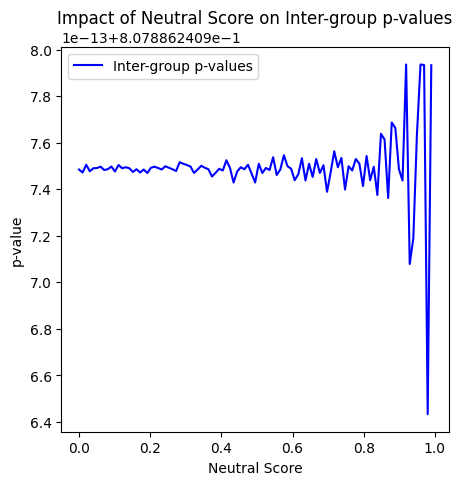

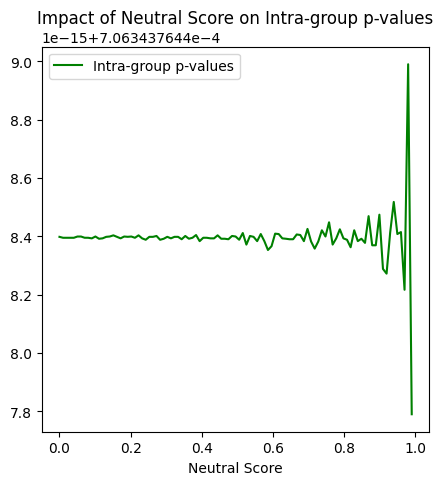

In [1]:
import json
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# 加载数据
data = json.load(open('data/checks.json'))

# Neutral值的可能范围
neutral_values = np.linspace(0, 1, 100)  # 从0到1，共100个值

# 记录结果
results = []

def compute_similarities(neutral_score):
    score_map = {
        "Entailment": 1,
        "Neutral": neutral_score,
        "Contradiction": 0
    }

    # 读取标签数据
    batch_labels = {
        "1_2": data["1_2"],
        "1_3": data["1_3"],
        "2_1": data["2_1"],
        "3_1": data["3_1"],
        "1_4": data["1_4"],
        "4_1": data["4_1"]
    }

    # 初始化相似度矩阵
    similarity_1_2 = np.zeros((10, 10))
    similarity_1_3 = np.zeros((10, 10))
    similarity_1_4 = np.zeros((10, 10))

    # 计算相似度矩阵
    for label_key in ["1_2", "2_1", "1_3", "3_1", "1_4", "4_1"]:
        group1, group2 = label_key.split('_')
        similarity_matrix = np.zeros((10, 10))
        for i in range(10):
            for j in range(10):
                score = 0
                length = 0
                for claims in batch_labels[label_key][i]:
                    score += score_map[claims[j]]
                    length += 1
                similarity_matrix[i][j] = score / length
        if label_key in ["1_2", "2_1"]:
            similarity_1_2 = similarity_matrix
        elif label_key in ["1_3", "3_1"]:
            similarity_1_3 = similarity_matrix
        else:
            similarity_1_4 = similarity_matrix

    # 进行t检验
    t1, p1 = ttest_ind(similarity_1_2.flatten(), similarity_1_3.flatten())
    t2, p2 = ttest_ind(similarity_1_2.flatten(), similarity_1_4.flatten())
    
    return p1, p2

# 改变Neutral值，计算影响
for neutral in neutral_values:
    p1, p2 = compute_similarities(neutral)
    results.append((neutral, p1, p2))


# 绘制Inter-group p-values
plt.figure(figsize=(5, 5))
neutral_scores, p_values_inter, _ = zip(*results)
plt.plot(neutral_scores, p_values_inter, label='Inter-group p-values', color='blue')
plt.xlabel('Neutral Score')
plt.ylabel('p-value')
plt.title('Impact of Neutral Score on Inter-group p-values')
plt.legend()
plt.savefig('p_values_inter_plot.pdf', format='pdf')
plt.show()

# 绘制Intra-group p-values
plt.figure(figsize=(5, 5))
_, _, p_values_intra = zip(*results)
plt.plot(neutral_scores, p_values_intra, label='Intra-group p-values', color='green')
plt.xlabel('Neutral Score')
plt.title('Impact of Neutral Score on Intra-group p-values')
plt.legend()
plt.savefig('p_values_intra_plot.pdf', format='pdf')
plt.show()
